In [1]:
# PUSH CODE

In [2]:
# ALL PACKAGES NEEDED:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from collections import namedtuple
from skimage.filters import threshold_local
from skimage import segmentation, measure
from imutils import perspective, paths
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from collections import defaultdict
import copy

import argparse
import imutils

# TEST

In [3]:
# Crop hard images based on bounding boxes
# Images with more than one bounding box will be cropped
# X number of times based on the number of bboxes
# Each cropped bbox of the same image
# Will have a '-idx' after its name
# Listed in order based on the smallest x_min coordinate

# Ex. Cars420.jpg, Labels: [(x, y, w, h), (x2, y2, w2 ,h2)]
# Resultant cropped images: Cars420-1.jpg, Cars420-2.jpg

# LOCALIZATION

In [4]:
# METRICS
def get_iou(box1, box2):
    # Unpack coordinates
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate intersection coordinates
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    # Calculate area of intersection
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Calculate area of union
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou_value = inter_area / union_area if union_area > 0 else 0
    return iou_value

In [5]:
# Helper function to parse TXT labels with normalized values
def parse_txt_label(file_path, image_width, image_height):
    boxes = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(' ')
            _, norm_x, norm_y, norm_w, norm_h = map(float, parts)

            center_x = norm_x * image_width
            center_y = norm_y * image_height

            w = norm_w * image_width
            h = norm_h * image_height

            # Calculate the top-left corner (x1, y1)
            x1 = center_x - (w / 2)
            y1 = center_y - (h / 2)

            # Calculate the bottom-right corner (x2, y2)
            x2 = center_x + (w / 2)
            y2 = center_y + (h / 2)

            boxes.append((x1, y1, x2, y2))
    return boxes

# Helper function to parse XML labels
def parse_xml_label(file_path):
    boxes = []
    tree = ET.parse(file_path)
    root = tree.getroot()
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        x1 = float(bndbox.find('xmin').text)
        y1 = float(bndbox.find('ymin').text)
        x2 = float(bndbox.find('xmax').text)
        y2 = float(bndbox.find('ymax').text)
        boxes.append((x1, y1, x2, y2))
    return boxes

def process_images_and_labels(image_folder, txt_label_folder, xml_label_folder):
    """
    Process images and labels from the given folders and return a dictionary with image data and labels.

    Args:
        image_folder (str): Path to the folder containing images.
        txt_label_folder (str): Path to the folder containing text labels.
        xml_label_folder (str): Path to the folder containing XML labels.

    Returns:
        dict: A dictionary where keys are image filenames and values are dictionaries with 'image' and 'labels'.
    """
    # Initialize a dictionary to store image data and corresponding labels
    loc_dict = {}

    # List all image files
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]

    # Process each image file
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        # Load image to get its dimensions
        image = cv2.imread(image_path)
        image_height, image_width, _ = image.shape

        # Initialize list to store bounding boxes for the current image
        label_boxes = []

        clean_name = ""

        # Try finding corresponding TXT label
        txt_label_file = os.path.join(txt_label_folder, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))
        if os.path.exists(txt_label_file):
            label_boxes.extend(parse_txt_label(txt_label_file, image_width, image_height))

            # Clean the name
            # Try to split the base name by the dash to get the original name
            if '_' in image_file:
                clean_name, rest = image_file.split('_', 1)
                extension = rest[:3]
                clean_name = f"{clean_name}.{extension}"
            else:
                clean_name = image_file
        else:
            # Try finding corresponding XML label
            xml_label_file = os.path.join(xml_label_folder, image_file.replace('.jpg', '.xml').replace('.png', '.xml'))
            if os.path.exists(xml_label_file):
                label_boxes.extend(parse_xml_label(xml_label_file))
                clean_name = image_file

        # Store image and its labels in the dictionary
        loc_dict[clean_name] = {'image': np.array(image), 'labels': label_boxes}

    return loc_dict

In [6]:
class LicensePlateDetector:

	def __init__(self, image, minPlateW = 60, minPlateH = 20, minCharW = 40):
		# store the image to detect license plates in, the minimum width and height of the
		# license plate region, the number of characters to be detected in the license plate,
		# and the minimum width of the extracted characters
		self.image = image
		self.minPlateW = minPlateW
		self.minPlateH = minPlateH
		self.minCharW = minCharW

	def detect(self):
		# detect license plate regions in the image
		lpRegions = self.detectPlates()

		return lpRegions

	def detectPlates(self):
		# initialize the rectangular and square kernels to be applied to the image,
		# then initialize the list of license plate regions
		rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
		squareKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
		regions = []

		# convert the image to grayscale, and apply the blackhat operation
		gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
		blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

		# find regions in the image that are light
		light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKernel)
		light = cv2.threshold(light, 50, 255, cv2.THRESH_BINARY)[1]

		# compute the Scharr gradient representation of the blackhat image and scale the
		# resulting image into the range [0, 255]
		gradX = cv2.Sobel(blackhat,
			ddepth = cv2.CV_32F,
			dx = 1, dy = 0, ksize = -1)
		gradX = np.absolute(gradX)
		(minVal, maxVal) = (np.min(gradX), np.max(gradX))
		gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")

		# blur the gradient representation, apply a closing operating, and threshold the
		# image using Otsu's method
		gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
		gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
		thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

		# perform a series of erosions and dilations on the image
		thresh = cv2.erode(thresh, None, iterations = 2)
		thresh = cv2.dilate(thresh, None, iterations = 2)

		# take the bitwise 'and' between the 'light' regions of the image, then perform
		# another series of erosions and dilations
		thresh = cv2.bitwise_and(thresh, thresh, mask = light)
		thresh = cv2.dilate(thresh, None, iterations = 2)
		thresh = cv2.erode(thresh, None, iterations = 1)

		# find contours in the thresholded image
		cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

		# loop over the contours
		for c in cnts:
			# grab the bounding box associated with the contour and compute the area and
			# aspect ratio
			(w, h) = cv2.boundingRect(c)[2:]
			aspectRatio = w / float(h)

			# calculate extent for additional filtering
			shapeArea = cv2.contourArea(c)
			boundingboxArea = w * h
			extent = shapeArea / float(boundingboxArea)
			extent = int(extent * 100) / 100

			# compute the rotated bounding box of the region
			rect = cv2.minAreaRect(c)
			box = cv2.boxPoints(rect)

			# ensure the aspect ratio, width, and height of the bounding box fall within
			# tolerable limits, then update the list of license plate regions
			if (aspectRatio > 3 and aspectRatio < 6) and h > self.minPlateH and w > self.minPlateW and extent > 0.50:
				regions.append(box)

		# return the list of license plate regions
		return regions

In [7]:
def evaluate_localization(loc_dict):
  """
    Evaluate the localization performance of the license plate detector.

    Args:
        loc_dict (dict): A dictionary where keys are image filenames and values are dictionaries with 'image' and 'labels'.

    Returns:
        dict: A dictionary where keys are image filenames and values are a list of bounding boxes in x_min, y_min, x_max, y_max.
    """

  # Initialize counters
  total_true_positives = 0
  total_false_positives = 0
  total_false_negatives = 0

  # Initialize a dictionary to store predicted results
  predicted_results = {}

  for key in loc_dict:

      image_data = loc_dict[key]['image']
      label_data = loc_dict[key]['labels']  # Assuming label_data is a list of bounding boxes

      image_to_use = copy.deepcopy(image_data)

      print(f"[INFO] Processing {key}, with {len(label_data)} boxes.")

      # Initialize the license plate detector and detect the license plates and candidates
      lpd = LicensePlateDetector(image_to_use)
      plates = lpd.detect()

      matched_labels = set()
      true_positives = 0
      false_positives = 0
      false_negatives = len(label_data)

      # Store predictions
      predicted_bboxes = []

      for lpBox in plates:
          # Reconstruct lpBox
          lpBox = np.array(lpBox)

          # Identify the top-left and bottom-right corners
          x_min = np.min(lpBox[:, 0])
          y_min = np.min(lpBox[:, 1])
          x_max = np.max(lpBox[:, 0])
          y_max = np.max(lpBox[:, 1])

          # Calculate width and height
          w = x_max - x_min
          h = y_max - y_min

          # Detected bounding box
          detected_bbox = (x_min, y_min, w, h)

          # Validate the bounding box
          if x_min < 0 or y_min < 0 or x_max <= x_min or y_max <= y_min or w <= 1 or h <= 1:
              print(f"Invalid BBox detected and skipped: {detected_bbox}")
              continue  # Skip this bounding box if it's invalid

          predicted_bboxes.append((x_min, y_min, x_max, y_max))

          # Find the best match label
          best_iou = 0
          best_label = None

          for label_bbox in label_data:

              # put in format x, y, w, h
              l_x_min, l_y_min, l_x_max, l_y_max = label_bbox
              l_w = l_x_max - l_x_min
              l_h = l_y_max - l_y_min
              l_bbox = (l_x_min, l_y_min, l_w, l_h)

              if label_bbox in matched_labels:
                  continue  # Skip if this label has already been matched

              iou = get_iou(detected_bbox, l_bbox)
              if iou > best_iou:
                  best_iou = iou
                  best_label = label_bbox

          # Assign the detection to the label with the highest IoU above the threshold
          if best_iou > 0.5:
              matched_labels.add(best_label)
              true_positives += 1
              false_negatives -= 1
          else:
              false_positives += 1

          print(f"Detected BBox: {detected_bbox}, Best IoU: {best_iou}")

      # Accumulate the results
      total_true_positives += true_positives
      total_false_positives += false_positives
      total_false_negatives += false_negatives

      # Sort the predicted bounding boxes by x_min
      #predicted_bboxes.sort(key=lambda bbox: bbox[0])  # Sort by x_min

      # Store the predicted bounding boxes and images in the dictionary
      predicted_results[key] = {'image': image_to_use, 'labels': predicted_bboxes}

  # Calculate overall precision and recall
  overall_precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
  overall_recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0

  # Calculate F1 Score
  if overall_precision + overall_recall > 0:
      f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall)
  else:
      f1_score = 0

  print(f"Overall Precision: {overall_precision}, Overall Recall: {overall_recall}, F1: {f1_score}")

  return predicted_results

# CHARACTER SEGMENTATION

In [8]:
def convert_bounding_box(cropped_bounding_box, bounding_box_1):
    x_min_1, y_min_1, _, _ = bounding_box_1  # Assuming Bounding_Box_1 is in (x_min, y_min, x_max, y_max) format

    cropped_x_min, cropped_y_min, cropped_x_max, cropped_y_max = cropped_bounding_box

    original_x_min = cropped_x_min + x_min_1
    original_y_min = cropped_y_min + y_min_1
    original_x_max = cropped_x_max + x_min_1
    original_y_max = cropped_y_max + y_min_1

    return (original_x_min, original_y_min, original_x_max, original_y_max)

In [9]:
def clean_filename(filename):
    # Split the filename by the first underscore
    base_name, rest = filename.split('_', 1)

    # Extract the next 3 characters after the underscore
    extension = rest[:3]

    # Try to split the base name by the dash to get the original name
    if '-' in base_name:
        og_name, _ = base_name.split('-', 1)
    else:
        og_name = base_name

    # Combine the base name with the correct extension
    cleaned_name = f"{og_name}.{extension}"

    return cleaned_name


# Need to change annotations_dict because some files might have two license plates
# Therefore, it should have two xml files
# Therefore, there are more character bounding boxes in the same image, but
# They belong to different license plates
def parse_annotations(loc_dict, annotations_folder):
    annotations_dict = {}

    for xml_file in os.listdir(annotations_folder):
        if not xml_file.endswith('.xml'):
            continue

        tree = ET.parse(os.path.join(annotations_folder, xml_file))
        root = tree.getroot()
        xml_filename = root.find('filename').text

        # Clean the filename to match the actual image filenames
        image_name = clean_filename(xml_filename)

        label_data = loc_dict[image_name]['labels']

        boxes_and_labels = []

        # Extract the size information
        size = root.find('size')
        if size is not None:
            cropped_width = int(size.find('width').text)
            cropped_height = int(size.find('height').text)

        # Find the closest matching ground truth bbox based on width and height
        # This is so that the following chara bboxes can be "normalized"
        # To uncropped image
        closest_bbox = None
        min_diff = float('inf')

        for gt_bbox in label_data:
            gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_bbox
            gt_width = gt_xmax - gt_xmin
            gt_height = gt_ymax - gt_ymin

            # Calculate the difference in dimensions
            width_diff = abs(gt_width - cropped_width)
            height_diff = abs(gt_height - cropped_height)
            total_diff = width_diff + height_diff

            # Update the closest_bbox if this one is a better match
            if total_diff < min_diff:
                min_diff = total_diff
                closest_bbox = gt_bbox

        # Get bboxes and "normalize"

        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            label = obj.find('name').text  # Extract the class label

            cropped_bbox = (xmin, ymin, xmax, ymax)
            original_bbox = convert_bounding_box(cropped_bbox, closest_bbox)
            xmin, ymin, xmax, ymax = original_bbox

            boxes_and_labels.append(((xmin, ymin, xmax, ymax), label))

        # Check if there are already bboxes for other plates in same img
        if image_name in annotations_dict:
            annotations_dict[image_name].extend(boxes_and_labels)
        else:
            annotations_dict[image_name] = boxes_and_labels

    return annotations_dict

In [10]:
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(copy.deepcopy(img), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Sort contours based on area and keep the top 10
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:10]

    bounding_boxes = []

    for cntr in cntrs:
        # Detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # Checking the dimensions of the contour to filter out the characters by contour's size
        if lower_width < intWidth < upper_width and lower_height < intHeight < upper_height:
            bounding_boxes.append((intX, intY, intX + intWidth, intY + intHeight))
            print(f"Detected bounding box: {intX, intY, intX + intWidth, intY + intHeight}")

    return bounding_boxes


def segment_characters(image):
    # Preprocess cropped license plate image
    img_binary_lp = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[LP_WIDTH-3:LP_WIDTH, :] = 255
    img_binary_lp[:, LP_HEIGHT-3:LP_HEIGHT] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

    # Get contours within cropped license plate
    bounding_boxes = find_contours(dimensions, img_binary_lp)

    return bounding_boxes

In [11]:
def evaluate_segmentation(localized_dict, annotations_dict, output_folder):

    """
      Evaluate the segmentation performance of the license plate detector.

      Args:
          localized_dict (dict): A dictionary where keys are image filenames and values are dictionaries with 'image' and 'labels' which are x_min, y_min, x_max, y_max.
          annotations_dict (dict): A dictionary where keys are image filenames and values are a list of bounding boxes in x_min, y_min, x_max, y_max.
          output_folder (str): Path to the folder where the output images will be saved.
    """

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize counters
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    # Store predicted results in a dict
    predicted_results = {}

    for key in localized_dict:
        image_data = localized_dict[key]['image']
        license_bboxes = localized_dict[key]['labels']

        # To store output
        color_image = copy.deepcopy(image_data)  # For drawing colored bounding boxes

        # To segment
        image = cv2.cvtColor(copy.deepcopy(image_data), cv2.COLOR_BGR2GRAY) # make black and white

        # Get the ground truth boxes for this image
        # SHOULD BE NORMALIZED TO OG IMAGE
        gt_boxes_labels = annotations_dict.get(key, [])
        # Extract only the bounding boxes while maintaining the order
        ground_truth_boxes = [bbox for bbox, _ in gt_boxes_labels]

        matched_labels = set()
        true_positives = 0
        false_positives = 0
        false_negatives = len(ground_truth_boxes)

        # Get the predicted boxes for this image
        full_predicted_boxes = []

        for license_bbox in license_bboxes:
            license_bbox = tuple(map(int, license_bbox))
            x_min, y_min, x_max, y_max = license_bbox
            # Crop the image according to the bounding box
            plate_crop = image[y_min:y_max, x_min:x_max]

            # Segment characters
            detected_boxes = segment_characters(plate_crop)

            for i, detected_box in enumerate(detected_boxes):
                detected_boxes[i] = convert_bounding_box(detected_box, license_bbox)
                detected_boxes[i] = tuple(map(int, detected_boxes[i]))

            full_predicted_boxes.extend(detected_boxes)

        for detected_box in full_predicted_boxes:
            best_iou = 0
            best_label = None

            for gt_box in ground_truth_boxes:
                if gt_box in matched_labels:
                    continue

                iou = get_iou(detected_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_label = gt_box

            if best_iou > 0.5:
                matched_labels.add(best_label)
                true_positives += 1
                false_negatives -= 1
                 # Draw true positive (correct detection) in green
                cv2.rectangle(color_image, (detected_box[0], detected_box[1]), (detected_box[2], detected_box[3]), (0, 255, 0), 2)
            else:
                false_positives += 1
                # Draw false positive (wrong detection) in red
                cv2.rectangle(color_image, (detected_box[0], detected_box[1]), (detected_box[2], detected_box[3]), (0, 0, 255), 2)

        # Draw false negatives (missed ground truth) in blue
        for gt_box in ground_truth_boxes:
            if gt_box not in matched_labels:
                gt_box = tuple(map(int, gt_box))
                cv2.rectangle(color_image, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 0, 0), 2)

        # Save the image with bounding boxes drawn
        output_image_path = os.path.join(output_folder, key)
        cv2.imwrite(output_image_path, color_image)

        total_true_positives += true_positives
        total_false_positives += false_positives
        total_false_negatives += false_negatives

        # Store predicted bboxes
        predicted_results[key] = full_predicted_boxes

    # Calculate overall precision and recall
    overall_precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    overall_recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0

    # Calculate F1 Score
    if overall_precision + overall_recall > 0:
        f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall)
    else:
        f1_score = 0

    print(f"Overall Precision: {overall_precision}")
    print(f"Overall Recall: {overall_recall}")
    print(f"F1 Score: {f1_score}")

    return predicted_results

# CLASSIFICATION

In [12]:
# TO USE WHEN TESTING COMPONENT
def create_character_crops_label(loc_dict, annotations_dict, output_folder):
    character_crops_dict = {}

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for key in loc_dict:
        image_data = loc_dict[key]['image']

        image = copy.deepcopy(image_data)

        # Get the ground truth bounding boxes and labels for this image
        boxes_and_labels = annotations_dict.get(key, [])

        # Initialize a list to hold the cropped character images and their labels
        character_crops = []

        # Sort boxes_and_labels by x_min value
        sorted_boxes_and_labels = sorted(boxes_and_labels, key=lambda x: x[0][0])

        for idx, (bbox, label) in enumerate(sorted_boxes_and_labels):
            x_min, y_min, x_max, y_max = bbox

            # Crop the image according to the bounding box
            character_crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]

            # Save the cropped character to the output folder
            crop_filename = f"{os.path.splitext(key)[0]}_char{idx+1}.png"
            crop_output_path = os.path.join(output_folder, crop_filename)
            cv2.imwrite(crop_output_path, character_crop)

            # Append the cropped character and label to the list
            character_crops.append((character_crop, label))

        # Store the list of cropped characters and labels in the dictionary
        character_crops_dict[key] = character_crops

    print("Character labelled crops complete.")
    return character_crops_dict


In [13]:
def create_character_labels_dict(character_crops_dict):
    character_labels_dict = {}

    for image_file, crops in character_crops_dict.items():
        # Extract just the labels from the list of (crop, label) tuples
        labels = [label for _, label in crops]
        character_labels_dict[image_file] = labels
    print("Character labels complete.")
    return character_labels_dict

In [14]:
def create_character_crops_pred(loc_dict, segmented_dict, output_folder):
    character_crops_dict = {}

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for key in loc_dict:
        image_data = loc_dict[key]['image']

        image = copy.deepcopy(image_data)

        # Get the bounding boxes for this image
        bboxes = segmented_dict.get(key, [])

        # Initialize a list to hold the cropped character images and their labels
        character_crops = []

        # Sort boxes by x_min value
        sorted_bboxes = sorted(bboxes, key=lambda bbox: bbox[0])

        for idx, bbox in enumerate(sorted_bboxes):
            x_min, y_min, x_max, y_max = bbox

            # Crop the image according to the bounding box
            character_crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]

            # Save the cropped character to the output folder
            crop_filename = f"{os.path.splitext(key)[0]}_char{idx+1}.png"
            crop_output_path = os.path.join(output_folder, crop_filename)
            cv2.imwrite(crop_output_path, character_crop)

            # Append the cropped character and label to the list
            character_crops.append(character_crop)

        # Store the list of cropped characters and labels in the dictionary
        character_crops_dict[key] = character_crops

    print("Character pred crops complete.")
    return character_crops_dict

In [15]:
def metrics_classification(y_true, y_pred, labels):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

    # Display metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    # Create a heatmap with seaborn
    plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Add labels, title, and adjust the axes
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # Optional: Display detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

In [16]:
# Define the model using AlexNet architecture
def model_create(num_classes, input_shape):
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11), strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.5))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

In [17]:
def preprocess_classify(original_image, TARGET_WIDTH, TARGET_HEIGHT, BORDER_SIZE):

  # Preprocessing the image
  rows, cols, _ = original_image.shape

  image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY) # make black and white

  # Apply binary thresholding with Otsu's method
  threshold_value = 120
  _, image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

  # Check the ratio of black to white pixels
  white_pixels = np.sum(image == 255)
  black_pixels = np.sum(image == 0)
  total_pixels = image.size
  black_white_ratio = black_pixels / total_pixels

  # Set thresholds for detecting skewed results
  min_ratio = 0.1  # Minimum acceptable black-to-white ratio
  max_ratio = 0.90  # Maximum acceptable black-to-white ratio

  # If the ratio is skewed, skip preprocessing
  if black_white_ratio < min_ratio or black_white_ratio > max_ratio:
      print("Thresholding failed, using original image.")
      barely_processed = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
      barely_processed = cv2.cvtColor(barely_processed, cv2.COLOR_GRAY2BGR) # keep 3 channels

      input_aspect_ratio = cols / rows
      target_aspect_ratio = TARGET_WIDTH / TARGET_HEIGHT

      # Determine new dimensions to maintain aspect ratio
      if input_aspect_ratio > target_aspect_ratio:
          # Wider image: match width and calculate padding for height
          new_cols = cols
          new_rows = int(cols / target_aspect_ratio)
      else:
          # Taller image: match height and calculate padding for width
          new_rows = rows
          new_cols = int(rows * target_aspect_ratio)

      # Calculate padding
      paddingY = (new_rows - rows) // 2
      paddingX = (new_cols - cols) // 2

      # Apply padding with white color (255, 255, 255)
      barely_processed = cv2.copyMakeBorder(barely_processed, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE, cv2.BORDER_CONSTANT, value=[255, 255, 255])
      barely_processed = cv2.copyMakeBorder(barely_processed, paddingY, paddingY, paddingX, paddingX, cv2.BORDER_CONSTANT, value=[255, 255, 255])

      # Resize image
      barely_processed = cv2.resize(barely_processed, (TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_CUBIC)
      return barely_processed  # Skip further processing and return the original image

  # Extract edge pixels
  top_edge = image[0, :]
  bottom_edge = image[-1, :]
  left_edge = image[:, 0]
  right_edge = image[:, -1]

  # Combine all edge pixels
  edge_pixels = np.concatenate((top_edge, bottom_edge, left_edge, right_edge))

  # Count the number of white and black edge pixels
  white_edge_pixels = np.sum(edge_pixels == 255)
  black_edge_pixels = np.sum(edge_pixels == 0)

  # Determine if inversion is needed based on edge pixels
  if black_edge_pixels > white_edge_pixels:
      image = cv2.bitwise_not(image)

  image = cv2.erode(image, (3,3))
  image = cv2.dilate(image, (3,3))

  image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) # keep 3 channels

  input_aspect_ratio = cols / rows
  target_aspect_ratio = TARGET_WIDTH / TARGET_HEIGHT

  # Determine new dimensions to maintain aspect ratio
  if input_aspect_ratio > target_aspect_ratio:
      # Wider image: match width and calculate padding for height
      new_cols = cols
      new_rows = int(cols / target_aspect_ratio)
  else:
      # Taller image: match height and calculate padding for width
      new_rows = rows
      new_cols = int(rows * target_aspect_ratio)

  # Calculate padding
  paddingY = (new_rows - rows) // 2
  paddingX = (new_cols - cols) // 2

  # Apply padding with white color (255, 255, 255)
  image = cv2.copyMakeBorder(image, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE, cv2.BORDER_CONSTANT, value=[255, 255, 255])
  image = cv2.copyMakeBorder(image, paddingY, paddingY, paddingX, paddingX, cv2.BORDER_CONSTANT, value=[255, 255, 255])

  # Resize image
  image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_NEAREST)

  return image


In [18]:
def evaluate_classification(model_path, character_crops_dict, character_labels_dict):

  labels = [
      '0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G',
      'H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'
      ]

  # Define constants
  TARGET_WIDTH = 128
  TARGET_HEIGHT = 128
  BORDER_SIZE = 1

  model = model_create(len(labels), (TARGET_HEIGHT, TARGET_WIDTH, 3))

  # Load the trained convolutional neural network
  model.load_weights(model_path)

  # Store predictions
  predicted_results = {}

  for image_name, character_crops in character_crops_dict.items():
      image_preds = []  # This will hold the predictions for this image

      for idx, original_image in enumerate(character_crops):

          image = preprocess_classify(copy.deepcopy(original_image), TARGET_WIDTH, TARGET_HEIGHT, BORDER_SIZE)

          image = image.astype("float") / 255.0  # Normalize to [0, 1]
          image = img_to_array(image)  # Convert to a Keras-compatible array
          image = np.expand_dims(image, axis=0)  # Add a batch dimension

          # Classify the input image
          print(f"[--] Classifying character {idx + 1} of {image_name}...")
          prob = model.predict(image)[0]  # Predict the probabilities
          predicted_idx = np.argsort(prob)[-1]  # Get the index of the class with the highest probability
          predicted_label = labels[predicted_idx]  # Map index to class label

          image_preds.append(predicted_label)  # Append the predicted label for this image

      predicted_results[image_name] = image_preds

  return predicted_results

# End-To-End

In [19]:
def calculate_ete_metrics(character_labels_dict, predicted_dict, labels):
    per_image_results = defaultdict(lambda: {'correct': 0, 'total': 0, 'predicted': 0})

    all_true_labels = []
    all_predicted_labels = []

    for image_file in character_labels_dict.keys():
        true_labels = character_labels_dict[image_file]
        predicted_labels = predicted_dict.get(image_file, [])

        # Accumulate for global metrics
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

        # Calculate per-image accuracy
        correct_predictions = sum(1 for true_label, pred_label in zip(true_labels, predicted_labels) if true_label == pred_label)
        total_labels = len(true_labels)
        predicted_labels_count = len(predicted_labels)

        per_image_results[image_file]['correct'] = correct_predictions
        per_image_results[image_file]['total'] = total_labels
        per_image_results[image_file]['predicted'] = predicted_labels_count

    # Truncate all_true_labels and all_predicted_labels to the same length
    min_len = min(len(all_true_labels), len(all_predicted_labels))
    truncated_true_labels = all_true_labels[:min_len]
    truncated_predicted_labels = all_predicted_labels[:min_len]

    # Global metrics
    overall_accuracy = accuracy_score(truncated_true_labels, truncated_predicted_labels)
    overall_precision = precision_score(truncated_true_labels, truncated_predicted_labels, average='macro', zero_division=0)
    overall_recall = recall_score(truncated_true_labels, truncated_predicted_labels, average='macro', zero_division=0)
    overall_f1 = f1_score(truncated_true_labels, truncated_predicted_labels, average='macro', zero_division=0)

    conf_matrix = confusion_matrix(truncated_true_labels, truncated_predicted_labels, labels=labels)
    # Create a heatmap with seaborn
    plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Add labels, title, and adjust the axes
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Overall Accuracy: {overall_accuracy}")
    print(f"Overall Precision: {overall_precision}")
    print(f"Overall Recall: {overall_recall}")
    print(f"Overall F1 Score: {overall_f1}")

    return per_image_results


In [20]:
def check_gt(loc_dict, annotations_dict, output_folder):

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for key in loc_dict:
        image_data = loc_dict[key]['image']
        license_bboxes = loc_dict[key]['labels']

        color_image = copy.deepcopy(image_data)

        # Get the ground truth boxes for this image
        # SHOULD BE NORMALIZED TO OG IMAGE
        gt_boxes_labels = annotations_dict.get(key, [])
        # Extract only the bounding boxes while maintaining the order
        ground_truth_boxes = [bbox for bbox, _ in gt_boxes_labels]

        for license_box in license_bboxes:
          license_box = tuple(map(int, license_box))
          cv2.rectangle(color_image, (license_box[0], license_box[1]), (license_box[2], license_box[3]), (0, 255, 0), 2)

        # Draw false negatives (missed ground truth) in blue
        for gt_box in ground_truth_boxes:
          gt_box = tuple(map(int, gt_box))
          cv2.rectangle(color_image, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 0, 0), 2)

        # Save the image with bounding boxes drawn
        output_image_path = os.path.join(output_folder, key)
        cv2.imwrite(output_image_path, color_image)

In [21]:
def check_pred_loc(localized_dict, output_folder):

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for key in localized_dict:
        image_data = localized_dict[key]['image']
        license_bboxes = localized_dict[key]['labels']

        color_image = copy.deepcopy(image_data)

        for license_box in license_bboxes:
          license_box = tuple(map(int, license_box))
          cv2.rectangle(color_image, (license_box[0], license_box[1]), (license_box[2], license_box[3]), (0, 0, 255), 2)

        # Save the image with bounding boxes drawn
        output_image_path = os.path.join(output_folder, key)
        cv2.imwrite(output_image_path, color_image)

In [22]:
easy_dict = process_images_and_labels('/content/drive/MyDrive/data/easy',
                                      '/content/drive/MyDrive/data/easy_labels',
                                      '/content/drive/MyDrive/data/easy_labels')
#hard_dict = process_images_and_labels('/content/drive/MyDrive/data/hard','/content/drive/MyDrive/data/hard_labels','/content/drive/MyDrive/data/hard_labels')

easy_localized_dict = evaluate_localization(easy_dict)
# hard_localized_dict = evaluate_localization(hard_dict)

[INFO] Processing Cars118.png, with 1 boxes.
Detected BBox: (219.0, 176.0, 151.0, 26.0), Best IoU: 0.3756218905472637
[INFO] Processing Cars128.png, with 1 boxes.
[INFO] Processing Cars123.png, with 1 boxes.
[INFO] Processing Cars0.png, with 1 boxes.
Detected BBox: (233.74269, 121.63599, 192.71483, 48.19635), Best IoU: 0.8105606693934532
[INFO] Processing Cars12.png, with 1 boxes.
[INFO] Processing Cars111.png, with 1 boxes.
Detected BBox: (327.1368, 172.98462, 144.65735, 28.339691), Best IoU: 0.6611102134484358
[INFO] Processing Cars109.png, with 1 boxes.
Detected BBox: (123.0, 122.0, 136.0, 27.0), Best IoU: 0.6088542530260321
[INFO] Processing Cars120.png, with 1 boxes.
[INFO] Processing Cars102.png, with 1 boxes.
[INFO] Processing Cars116.png, with 1 boxes.
Detected BBox: (136.52602, 212.82817, 139.67705, 32.683197), Best IoU: 0.6847736738100714
Invalid BBox detected and skipped: (99.723206, -3.653909, 119.59198, 30.339046)
[INFO] Processing Cars11.png, with 1 boxes.
Detected BBox: 

In [23]:
# ======== ======== ======== ========
annotations_folder = '/content/drive/MyDrive/data/easy_segmented'
# cropped_images_folder = '/content/drive/MyDrive/data/easy_cropped'
output_folder = '/content/drive/MyDrive/data/easy_charas_test'

loc_dict = easy_dict
# loc_dict = hard_dict
localized_dict = easy_localized_dict
# localized_dict = hard_localized_dict

seg_labels_dict = parse_annotations(loc_dict, annotations_folder)
segmented_dict = evaluate_segmentation(localized_dict, seg_labels_dict, output_folder)

Detected bounding box: (54, 17, 72, 46)
Detected bounding box: (19, 18, 36, 46)
Detected bounding box: (180, 2, 191, 46)
Detected bounding box: (106, 14, 121, 44)
Detected bounding box: (89, 15, 105, 45)
Detected bounding box: (138, 12, 153, 42)
Detected bounding box: (152, 12, 168, 41)
Detected bounding box: (167, 11, 183, 40)
Detected bounding box: (3, 8, 17, 27)
Detected bounding box: (49, 6, 61, 27)
Detected bounding box: (121, 3, 132, 25)
Detected bounding box: (108, 4, 119, 26)
Detected bounding box: (18, 8, 30, 27)
Detected bounding box: (79, 5, 91, 27)
Detected bounding box: (133, 3, 142, 25)
Detected bounding box: (66, 6, 78, 27)
Detected bounding box: (35, 7, 47, 27)
Detected bounding box: (2, 2, 9, 25)
Detected bounding box: (52, 2, 58, 25)
Detected bounding box: (124, 7, 130, 23)
Detected bounding box: (17, 10, 31, 29)
Detected bounding box: (33, 10, 45, 29)
Detected bounding box: (91, 4, 98, 28)
Detected bounding box: (28, 10, 35, 25)
Detected bounding box: (135, 11, 147, 

In [24]:
check_gt(easy_dict, seg_labels_dict, '/content/drive/MyDrive/data/easy_gt_CHECK')

In [25]:
check_pred_loc(localized_dict, '/content/drive/MyDrive/data/easy_loc_CHECK')

In [24]:
# ======== ======== ======== ========
# images_folder = '/content/drive/MyDrive/data/easy_cropped'
images_folder = '/content/drive/MyDrive/data/easy'
gt_output_folder = '/content/drive/MyDrive/data/cropped_TEST'
output_folder = '/content/drive/MyDrive/data/easy_pred_cropped'

# Create the character crops and save them to the output folder
# Assumes seg_labels_dict has OG coordinate system, not cropped
character_crops_gt_dict = create_character_crops_label(loc_dict, seg_labels_dict, output_folder)
character_crops_pred_dict = create_character_crops_pred(loc_dict, segmented_dict, output_folder)
character_labels_dict = create_character_labels_dict(character_crops_gt_dict)

model_path = '/content/drive/MyDrive/data/characters_model_converted.h5'

final_preds_dict = evaluate_classification(model_path, character_crops_pred_dict, character_labels_dict)

Character labelled crops complete.
Character pred crops complete.
Character labels complete.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[--] Classifying character 1 of Cars0.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[--] Classifying character 2 of Cars0.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[--] Classifying character 3 of Cars0.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[--] Classifying character 4 of Cars0.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[--] Classifying character 5 of Cars0.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[--] Classifying character 6 of Cars0.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[--] Classifying character 7 of Cars0.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[--] Classifying character 8 of Cars0.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[--] Classifying character 1 of Cars111.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[--] Classifying character 2 of Cars111.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[--] Classifying character 3 of Cars111.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[--] Classifying character 4 of Cars111.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/

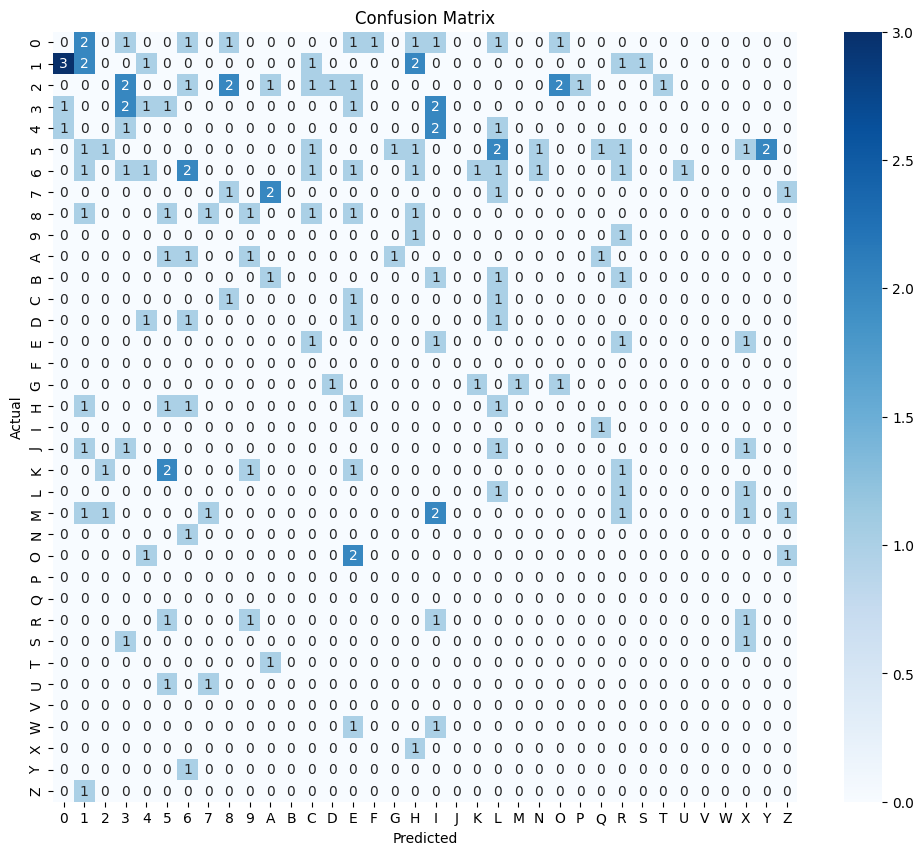

Overall Accuracy: 0.04430379746835443
Overall Precision: 0.020274170274170274
Overall Recall: 0.026257076257076257
Overall F1 Score: 0.020921823274764453
Cars118.png: Correct=0, Total=7, Predicted=0, Accuracy=0.00
Cars128.png: Correct=0, Total=7, Predicted=0, Accuracy=0.00
Cars123.png: Correct=0, Total=10, Predicted=0, Accuracy=0.00
Cars0.png: Correct=0, Total=10, Predicted=8, Accuracy=0.00
Cars12.png: Correct=0, Total=10, Predicted=0, Accuracy=0.00
Cars111.png: Correct=4, Total=10, Predicted=9, Accuracy=0.40
Cars109.png: Correct=0, Total=7, Predicted=3, Accuracy=0.00
Cars120.png: Correct=0, Total=7, Predicted=0, Accuracy=0.00
Cars102.png: Correct=0, Total=7, Predicted=0, Accuracy=0.00
Cars116.png: Correct=0, Total=6, Predicted=2, Accuracy=0.00
Cars11.png: Correct=0, Total=7, Predicted=2, Accuracy=0.00
Cars167.png: Correct=1, Total=9, Predicted=7, Accuracy=0.11
Cars177.png: Correct=0, Total=4, Predicted=0, Accuracy=0.00
Cars18.png: Correct=0, Total=7, Predicted=2, Accuracy=0.00
Cars219

In [27]:
# Evaluate end-to-end results

results = calculate_ete_metrics(character_labels_dict, final_preds_dict, [
      '0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G',
      'H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'
      ])

# Analyze per-image results
for image_file, metrics in results.items():
    correct = metrics['correct']
    total = metrics['total']
    predicted = metrics['predicted']
    per_image_accuracy = correct / total if total > 0 else 0
    print(f"{image_file}: Correct={correct}, Total={total}, Predicted={predicted}, Accuracy={per_image_accuracy:.2f}")